LQR Gain K: [[1.18773852 7.87727069]]
J*(x0): 356.00121726610064
Optimal control u_0: [1.]
Optimal c values: [[ 5.96940357e+00  5.24945950e+00  4.39340933e+00  3.39084802e+00
   2.23016977e+00 -5.18790878e-01 -1.74003900e+00 -1.99755622e+00
  -2.14669356e+00 -2.18331964e+00 -2.10255456e+00 -1.79742380e+00
  -1.25605325e+00 -8.07620453e-01 -4.64096956e-01 -2.19482798e-01
  -5.86131479e-02  3.68985217e-02  8.50051496e-02  1.01267632e-01
   9.80645844e-02  8.45394333e-02  6.69593954e-02  4.92579397e-02
   3.36130968e-02  2.09761129e-02  1.15093768e-02  4.92191461e-03
   7.08300653e-04 -1.69421391e-03]]
Trajectory of states:
From (-7.500, 0.500) to (-0.004, 0.001)


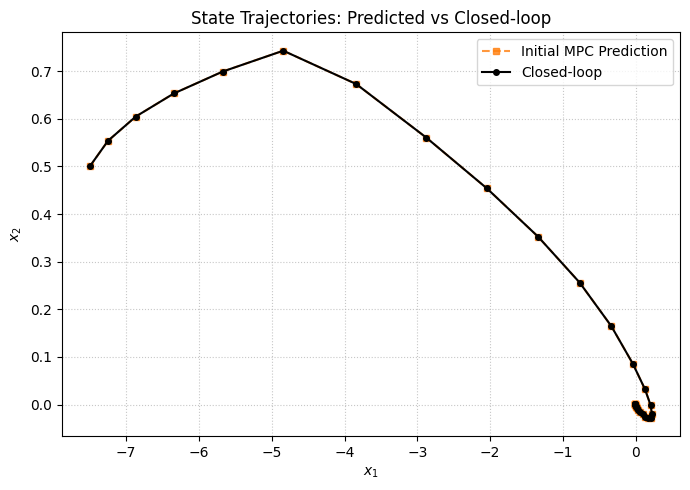

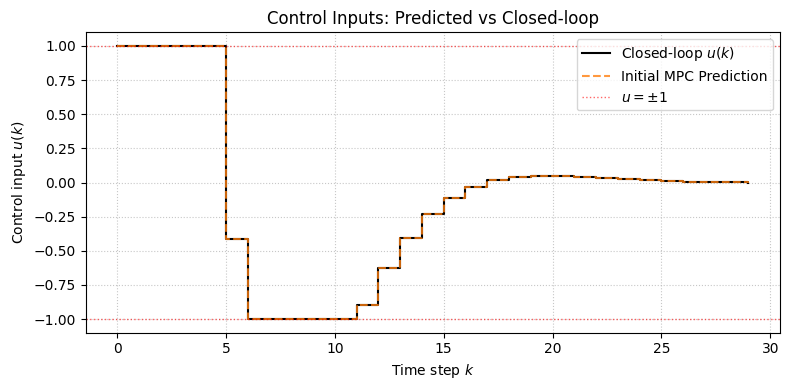

In [98]:
import numpy as np
import cvxpy as cp
from scipy.linalg import solve_discrete_are
import matplotlib.pyplot as plt


#=============================
# Based on Cannon (2016), p.23 
#=============================

# ----- System definition -----
A = np.array([[1.1, 2.0],
              [0.0, 0.95]])
B = np.array([[0.0],
              [0.0787]])
C = np.array([[-1.0, 1.0]])  # 1x2
Q = C.T @ C
R = np.array([[1.0]])

# ----- Compute LQR gain -----
def lq_gain(A, B, Q=Q, R=R):
    P = solve_discrete_are(A, B, Q, R)
    K = np.linalg.solve(B.T @ P @ B + R, B.T @ P @ A)
    return K, P

K, P = lq_gain(A, B)
print("LQR Gain K:", K)

# ----- Define F and G -----
F = np.array([[0, 1/8],
              [1/8, 0],
              [0, -1/8],
              [-1/8, 0],
              [0, 0],
              [0, 0]])
G = np.array([0, 0, 0, 0, 1, -1]).reshape(-1, 1)

def compute_nu(F, G, K, A, B, n_max=10):
    FGK = F + G @ K
    AK = A + B @ K
    nC = FGK.shape[0]
    dim_x = A.shape[0]
    x = cp.Variable(dim_x)

    for n in range(n_max):
        # create constraints for i = 0 to n
        constraints = [(FGK @ np.linalg.matrix_power(AK, i)) @ x <= np.ones(nC) for i in range(n + 1)]

        Phi_np1 = np.linalg.matrix_power(AK, n + 1)
        expr = (FGK @ Phi_np1) @ x

        # for each row j, maximize row_j * Phi^(n+1) x
        max_violations = []
        for j in range(FGK.shape[0]):
            prob = cp.Problem(cp.Maximize(expr[j]), constraints)
            prob.solve(cp.SCS)
            if prob.status != "optimal":
                return n  # infeasible earlier
            max_violations.append(prob.value)  

        # If all rows <= 1, then invariant reached
        if all(v <= 1.0 + 1e-6 for v in max_violations):
            return n

    return n_max

def compute_VT(F, G, K, A, B):
    nu = compute_nu(F, G, K, A, B, 10)  
    FGK = F + G @ K
    AK = A + B @ K
    VT_blocks = []
    for i in range(nu + 1):
        VT_blocks.append(FGK @ np.linalg.matrix_power(AK, i))
    return np.vstack(VT_blocks)
        
#=============================
# Values taken from Cannon (2016), p.30
#=============================

def MPC(F, G, A, B, x0, N=6):
    K, P = lq_gain(A, B)  
    nx = A.shape[0]
    nu = B.shape[1]  # = 1

    c = cp.Variable((nu, N))      # c is (1, N)
    x = cp.Variable((nx, N+1))    # x is (2, N+1)

    # Precompute matrices
    FGK = F + G @ K               # (6, 2)
    AK = A + B @ K                # (2, 2)
    VT = compute_VT(F, G, K, A, B)  # terminal set

    cost = 0
    constraints = [x[:, 0] == x0]

    for i in range(N):
        # Dynamics in c-parameterized form: x⁺ = AK x + B c
        constraints += [x[:, i+1] == AK @ x[:, i] + B @ c[:, i]]

        # Stage cost: u = Kx + c
        u_i = K @ x[:, i] + c[:, i]   # (1,)
        cost += cp.quad_form(x[:, i], Q) + cp.quad_form(u_i, R)

        # Constraint: F x + G u <= 1  →  (F + G K) x + G c <= 1
        # Ensure G @ c[:, i] is (6,)
        Gc = G @ c[:, i]  # G: (6,1), c[:,i]: (1,) → Gc: (6,)
        constraints += [FGK @ x[:, i] + Gc <= np.ones(F.shape[0])]

    # Terminal cost
    cost += cp.quad_form(x[:, N], P)

    # Terminal constraint
    constraints += [VT @ x[:, N] <= np.ones(VT.shape[0])]

    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.OSQP, verbose=False)

    if prob.status == "optimal":
        u0 = (K @ x0 + c[:, 0].value).flatten()
        return cost.value, u0, c.value, x.value
    else:
        print(f"MPC failed: {prob.status}")
        return None, None, None, None

x0 = np.array([-7.5, 0.5]).reshape(-1)
cost, u_opt, c_opt, x_opt = MPC(F, G, A, B, x0, N=30)

x1 = x_opt[0, :]
x2 = x_opt[1, :]
if u_opt is not None:
    print("J*(x0):", cost)
    print("Optimal control u_0:", u_opt)
    print("Optimal c values:", c_opt)
    print("Trajectory of states:")
    print(f"From ({x0[0]:.3f}, {x0[1]:.3f}) to ({x1[-1]:.3f}, {x2[-1]:.3f})")


# ======================================
# Save initial prediction for plotting
# ======================================
if c_opt is not None:
    u_pred_initial = np.array([K @ x_opt[:, k] + c_opt[:, k] for k in range(c_opt.shape[1])]).flatten()
else:
    u_pred_initial = None

# ======================================
# Closed-loop simulation
# ======================================
total_steps = 30
x_current = x0.copy()
x_history = [x_current]
u_history = []

for step in range(total_steps):
    cost, u_opt, c_opt_step, x_pred = MPC(F, G, A, B, x_current, N=20)
    if u_opt is None:
        print(f"MPC failed at step {step}")
        break
    u_current = u_opt.item()  # scalar
    u_history.append(u_current)
    x_next = A @ x_current + B.flatten() * u_current
    x_current = x_next
    x_history.append(x_current)

x_closed_loop = np.array(x_history).T
u_closed_loop = np.array(u_history)

# ======================================
# Plot 1: State Trajectories
# ======================================
plt.figure(figsize=(7, 5))
# Initial MPC predicted trajectory
plt.plot(x_opt[0, :], x_opt[1, :], 's--', color='C1', 
         label='Initial MPC Prediction', markersize=4, alpha=0.8)
# Closed-loop actual trajectory
plt.plot(x_closed_loop[0, :], x_closed_loop[1, :], 'o-', color='black', 
         label='Closed-loop', markersize=4)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('State Trajectories: Predicted vs Closed-loop')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# ======================================
# Plot 2: Control Inputs
# ======================================
plt.figure(figsize=(8, 4))
# Closed-loop inputs
plt.step(range(len(u_closed_loop)), u_closed_loop, where='post', 
         label='Closed-loop $u(k)$', color='black', linewidth=1.5)

if u_pred_initial is not None:
    plt.step(range(len(u_pred_initial)), u_pred_initial, where='post', 
             label='Initial MPC Prediction', linestyle='--', color='C1', alpha=0.8)

plt.axhline(1, color='red', linestyle=':', alpha=0.6, linewidth=1, label='$u = \\pm 1$')
plt.axhline(-1, color='red', linestyle=':', alpha=0.6, linewidth=1)

plt.xlabel('Time step $k$')
plt.ylabel('Control input $u(k)$')
plt.title('Control Inputs: Predicted vs Closed-loop')
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()